In [2]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric
import math
from math import sin, cos, sqrt, atan2, radians

In [3]:
head, tail = os.path.split(os.getcwd())
data_dir = os.path.join(head, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')
data_raw_dir

'/Users/Gagandeep/Desktop/Concordia/12 Winter 2021/SOEN 471/Project/data/raw'

In [4]:
rpt_dir = os.path.join(head, 'reports', 'figures')
rpt_dir

'/Users/Gagandeep/Desktop/Concordia/12 Winter 2021/SOEN 471/Project/reports/figures'

In [5]:
df_spots = pd.read_csv(os.path.join(data_raw_dir, 'Places.csv'), header=0, encoding='cp1252')
df_spots.head()

,sNoPlace,nLongitude,nLatitude,nPositionCentreLongitude,nPositionCentreLatitude,sStatut,sGenre,sType,sAutreTete,sNomRue,nSupVelo,sTypeExploitation,nTarifHoraire,sLocalisation,nTarifMax
0,A007,-73.581856,45.489593,-73.581870,45.489623,1,NORMAL,Double,A008,Sussex,0,Régulier Payez-Partez,350,S,NaN
1,A008,-73.581856,45.489593,-73.581806,45.489592,1,NORMAL,Double,A007,Sussex,0,Régulier Payez-Partez,350,S,NaN
2,A009,-73.581727,45.489532,-73.581740,45.489562,1,NORMAL,Double,A010,Sussex,0,Régulier Payez-Partez,350,S,NaN
3,A010,-73.581727,45.489532,-73.581676,45.489531,1,NORMAL,Double,A009,Sussex,0,Régulier Payez-Partez,350,S,NaN
4,A011,-73.581597,45.489471,-73.581611,45.489501,1,NORMAL,Double,A012,Sussex,0,Régulier Payez-Partez,350,S,NaN


In [6]:
print(df_spots.count())
len(df_spots['nLatitude'].unique())

sNoPlace                    18652
nLongitude                  18652
nLatitude                   18652
nPositionCentreLongitude    18652
nPositionCentreLatitude     18652
sStatut                     18652
sGenre                      18652
sType                       18652
sAutreTete                  13504
sNomRue                     18652
nSupVelo                    18652
sTypeExploitation           18652
nTarifHoraire               18652
sLocalisation               18652
nTarifMax                     666
dtype: int64


11900

In [7]:
spots = gpd.GeoDataFrame(df_spots, geometry=gpd.points_from_xy(df_spots.nPositionCentreLongitude, df_spots.nPositionCentreLatitude))
spots.head()

,sNoPlace,nLongitude,nLatitude,nPositionCentreLongitude,nPositionCentreLatitude,sStatut,sGenre,sType,sAutreTete,sNomRue,nSupVelo,sTypeExploitation,nTarifHoraire,sLocalisation,nTarifMax,geometry
0,A007,-73.581856,45.489593,-73.581870,45.489623,1,NORMAL,Double,A008,Sussex,0,Régulier Payez-Partez,350,S,NaN,POINT (-73.58187 45.48962)
1,A008,-73.581856,45.489593,-73.581806,45.489592,1,NORMAL,Double,A007,Sussex,0,Régulier Payez-Partez,350,S,NaN,POINT (-73.58181 45.48959)
2,A009,-73.581727,45.489532,-73.581740,45.489562,1,NORMAL,Double,A010,Sussex,0,Régulier Payez-Partez,350,S,NaN,POINT (-73.58174 45.48956)
3,A010,-73.581727,45.489532,-73.581676,45.489531,1,NORMAL,Double,A009,Sussex,0,Régulier Payez-Partez,350,S,NaN,POINT (-73.58168 45.48953)
4,A011,-73.581597,45.489471,-73.581611,45.489501,1,NORMAL,Double,A012,Sussex,0,Régulier Payez-Partez,350,S,NaN,POINT (-73.58161 45.48950)


## Get city of a parking spot

In [21]:
import json

from shapely.geometry import Point, mapping, shape
from shapely.ops import nearest_points

with open(os.path.join(data_raw_dir, 'montreal_boroughs.geojson')) as f:
    geojson = json.load(f)

# ref_point = Point(-73.58187,45.48962)




def get_city(ref_point):
    min_distance = None
    features = []
    for i, feature in enumerate(geojson["features"]):
        p1, p2 = nearest_points(shape(feature["geometry"]), ref_point)
        distance = p1.distance(p2)
        prop_org = feature["properties"]
        if min_distance is None or distance < min_distance:
            min_distance = distance
            # min_index = i

        feature["prop"] = {"distance": distance, "properties":prop_org}
        features.append(feature)
        features.append(
            {
                "type": "Feature",
                "prop": {"distance": distance, "properties":prop_org},
                "geometry": mapping(p1),
            }
        )

    features = sorted(features, key=lambda x: x["prop"]["distance"])

    features.append(
        {
            "type": "Feature",
            "prop": {"distance": 0, "properties":prop_org},
            "geometry": mapping(ref_point),
        }
    )
    return features[0]['properties']['NOM']


In [22]:
spots['Cities'] = spots['geometry'].map(get_city)

<AxesSubplot:>

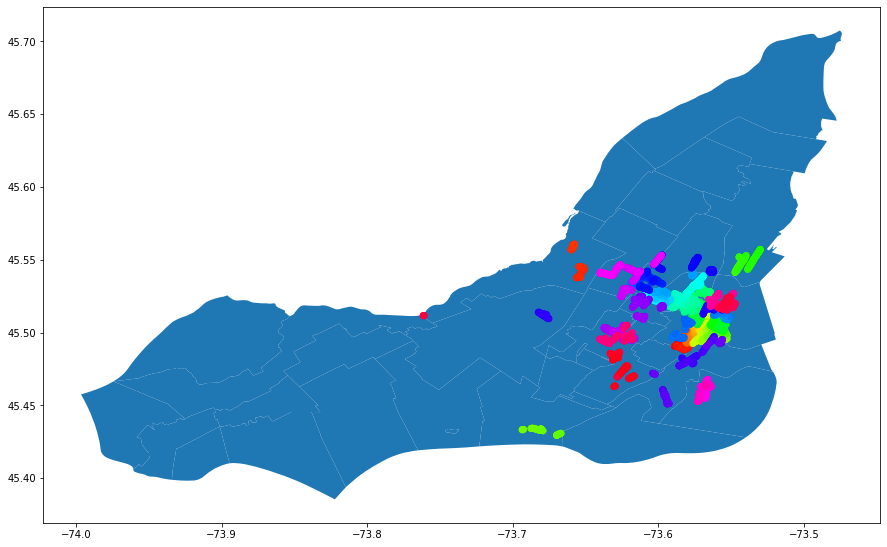

In [24]:
fig, ax = plt.subplots(1, figsize=(15, 15))
boroughs = gpd.read_file(os.path.join(data_raw_dir, 'montreal_boroughs.geojson'))
boroughs.plot(ax=ax)
spots.plot(ax=ax, marker='o', cmap = "hsv", alpha=0.5, label='Cities')